### Importing Libraries

In [59]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve
from IPython.display import Image  
import pydotplus
import warnings
warnings.filterwarnings('ignore')

In [31]:
!pip install pydotplus

     |████████████████████████████████| 286kB 1.4MB/s eta 0:00:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-cp37-none-any.whl size=24567 sha256=0225a6fe4089d4e5b54754ff970511d6452ca7582b860230918477a8dc2ac719
  Stored in directory: /Users/rock/Library/Caches/pip/wheels/35/7b/ab/66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus


In [39]:
!pip install graphviz

In [46]:
# Executed in Macos terminal
# !conda install graphviz

&nbsp;

### Loading Dataset

In [4]:
filepath = os.getcwd() + "/tennis.csv"
df = pd.read_csv(filepath)
df.head()

,outlook,temp,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes


&nbsp;

### Descriptive Analysis

In [5]:
print(df.info())
print('\nMissing values in given data :')
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
outlook     14 non-null object
temp        14 non-null object
humidity    14 non-null object
windy       14 non-null bool
play        14 non-null object
dtypes: bool(1), object(4)
memory usage: 590.0+ bytes
None

Missing values in given data :
outlook     0
temp        0
humidity    0
windy       0
play        0
dtype: int64


&nbsp;

### Dummy Variables Creation<span style='background:yellow'>(Instead of direct categorical variable, sklearn library works with encoded category variables to find Entropy and I.G for best splits)</span>

In [7]:
df_dummy = pd.get_dummies(data = df, columns=['outlook','temp','humidity','windy'])
df_dummy.head()

,play,outlook_overcast,outlook_rainy,outlook_sunny,temp_cool,temp_hot,temp_mild,humidity_high,humidity_normal,windy_False,windy_True
0,no,0,0,1,0,1,0,1,0,1,0
1,no,0,0,1,0,1,0,1,0,0,1
2,yes,1,0,0,0,1,0,1,0,1,0
3,yes,0,1,0,0,0,1,1,0,1,0
4,yes,0,1,0,1,0,0,0,1,1,0


&nbsp;

### Train & Test split

In [8]:
X = df_dummy.drop(['play'],axis=1)
y = df_dummy['play']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 101 )

&nbsp;

### Hyperparameters Optimization

In [16]:
#Create dictionary of all values that we want to test
param_grid = { "criterion" : ['entropy','gini'],
               "max_depth" : np.arange(2,5),
               "max_features" : np.arange(2,5),
               #'max_features': ['auto', 'sqrt', 'log2']
               "n_estimators" : np.arange(1,30)  #Number of decision trees
             }

#Random Forecast Classifier
rtree_model = RandomForestClassifier()

#Use gridsearch to test all possible parameters for best accuracy
rtree_gscv = GridSearchCV(rtree_model, param_grid = param_grid, cv = 5)

#Fit model to data
rtree_gscv.fit(X_train, y_train)

#GridSearch Results
print("Best paramters/estimators as per gridsearc cross validation. {}".format(rtree_gscv.best_params_))
print('Mean accuray as per best parameters : {}\n'.format(rtree_gscv.best_score_))

#Below prints all the parameters combination and its kfolds mean accuracy  
# print('GridSearch all parameters :')
# print(rtree_gscv.cv_results_['params'],'\n')
# print('GridSearch all parameters kfolds mean accuracy:')
# print(rtree_gscv.cv_results_['mean_test_score'])

Best paramters/estimators as per gridsearc cross validation. {'criterion': 'gini', 'max_depth': 3, 'max_features': 2, 'n_estimators': 19}
Mean accuray as per best parameters : 0.8888888888888888



#### Key Note
* n_estimators = number of trees in the foreset
* max_features = max number of features considered for splitting a node(i.e., [ max_features ] is the size of the random subsets of features to consider when splitting a node. (or) column sampling )
* max_depth = max number of levels in each decision tree
* min_samples_split = min number of data points placed in a node before the node is split
* min_samples_leaf = min number of data points allowed in a leaf node
* bootstrap = method for sampling data points (with or without replacement)

&nbsp;

### Best Model Parameters as per Gridsearch_csv

In [17]:
#Random Forecast Classifier

rtree = RandomForestClassifier(criterion='gini', max_depth=3, max_features=2, n_estimators=19)
rtree

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features=2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=19,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

&nbsp;

### Model Fit

In [49]:
rtree.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features=2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=19,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

&nbsp;

### Trained Random Forest Tree Visualization

#### Using export_graphviz, ploting 2nd decision tree out of 19 estimators(i.e., base decision trees)

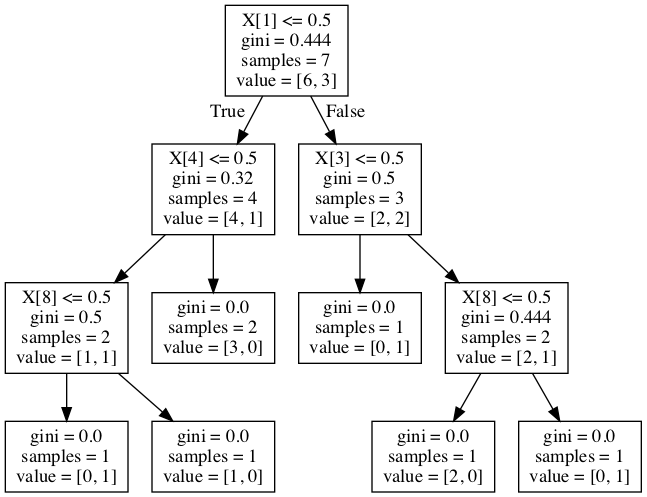

In [51]:
tree_count = 0
for tree_in_random_forest in rtree.estimators_:
    if (tree_count ==1):        
        rfr_file = export_graphviz(tree_in_random_forest, out_file=None)
        rfr_graph = pydotplus.graph_from_dot_data(rfr_file)        
    tree_count = tree_count + 1
Image(rfr_graph.create_png())

&nbsp;

#### Using plot_tree, ploting 2nd decision tree out of 19 estimators(i.e., base decision trees)

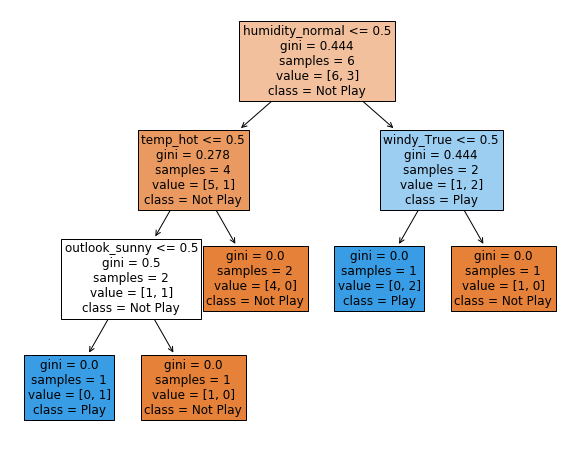

In [48]:
fig = plt.figure(figsize=(10,8))
a = plot_tree(rtree.estimators_[1], feature_names=X_train.columns, fontsize=12, filled=True, class_names=['Not Play', 'Play'])#Because in our data 1st class label is not play in resp. variable
plt.show()

#### Key Note
* we can see how 2nd decision tree trained out of 19 decision trees in random forest based on our best hyper parameters.
* Both graphs are perfectly same with nodes and splits.

&nbsp;

### Model Performance

In [53]:
print("X_train sample counts : {}".format(len(X_train)))
print("y_test sample counts : {}\n".format(len(X_test)))


y_pred = rtree.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples: {}\n'.format(count_misclassified))

confusion = metrics.confusion_matrix(y_test,y_pred)

print('Confusion Matrix:')
print(confusion,'\n')
sensitivity = confusion[1][1]/float(confusion[1:].sum())
specificity = confusion[0][0]/float(confusion[:,0].sum())
specificity_ = confusion[0][1]/float(confusion[:,0].sum()) 
print("The accuracy (TP+TN)/total : {0:.3f}\n".format(accuracy))
print("The sensitivity (TP/TP+FN) | TPR : {0:.3f}\n".format(sensitivity))
print("The specificity (TN/TN+FP) : {0:.3f}\n".format(specificity))
print("The 1-specificity (FP/TN+FP) | FPR : {0:.3f}\n".format(specificity_))

X_train sample counts : 9
y_test sample counts : 5

Misclassified samples: 0

Confusion Matrix:
[[1 0]
 [0 4]] 

The accuracy (TP+TN)/total : 1.000

The sensitivity (TP/TP+FN) | TPR : 1.000

The specificity (TN/TN+FP) : 1.000

The 1-specificity (FP/TN+FP) | FPR : 0.000



&nbsp;

### Model Probabilities

In [54]:
probs = rtree.predict_proba(X_test)
print('Probabilities on y_test : {}\n'.format(probs.tolist()))
print('if pred. value is \'yes\' then prob. is [0.0, 1.0], if pred. value is \'no\' the prob. is [1.0, 0.0]\n')
print('Actual y_test value : {}\n'.format(y_test.tolist()))
print('Predictions on y_test : {}\n'.format(y_pred.tolist()))
probs = probs[:, 1]
print('As AUC_ROC mainly of postive cases, we take postive case probablities : {}\n'.format(probs))

Probabilities on y_test : [[0.2631578947368421, 0.7368421052631579], [0.42105263157894735, 0.5789473684210527], [0.3684210526315789, 0.631578947368421], [0.5263157894736842, 0.47368421052631576], [0.4473684210526316, 0.5526315789473685]]

if pred. value is 'yes' then prob. is [0.0, 1.0], if pred. value is 'no' the prob. is [1.0, 0.0]

Actual y_test value : ['yes', 'yes', 'yes', 'no', 'yes']

Predictions on y_test : ['yes', 'yes', 'yes', 'no', 'yes']

As AUC_ROC mainly of postive cases, we take postive case probablities : [0.73684211 0.57894737 0.63157895 0.47368421 0.55263158]



&nbsp;

### AUC value(on y_test and y_pred postive probablities for calculating TPR and FPR)¶

In [57]:
#Its calculating area under the roc curve
auc = roc_auc_score(y_test, probs)
print('AUC: %.2f' % auc)

AUC: 1.00


&nbsp;

### Getting TPR,FPR calculated based on postive y_pred probablities and it selects few optimal thresholds for better curve

In [71]:
y_test_1 = [1 if i == 'yes' else 0 for i in y_test]
print("Actual y's : {}\n".format(y_test.tolist()))
print("Actual y's converted into numeric : {}\n".format(y_test_1))
print("Postive Probablities : {}\n".format(probs))
fpr, tpr, thresholds = roc_curve(y_test_1, probs)
print("tpr, fpr : {}, {}\n".format(tpr,fpr))
print("Thresholds for ROC curve : {}".format(thresholds))

Actual y's : ['yes', 'yes', 'yes', 'no', 'yes']

Actual y's converted into numeric : [1, 1, 1, 0, 1]

Postive Probablities : [0.73684211 0.57894737 0.63157895 0.47368421 0.55263158]

tpr, fpr : [0.   0.25 1.   1.  ], [0. 0. 0. 1.]

Thresholds for ROC curve : [1.73684211 0.73684211 0.55263158 0.47368421]


#### Key Note:
* We can see here threshold 1st value 1.73684 which is highest where both tpr & fpr gets 0.
* At threshold last value 0.47368 where both tpr and fpr get 1.
* & at 0.7368 & 0.5526 threshold values, our roc curve checks tpr and fpr values.
* On a whole, roc curve makes thresholds cleverly according to our y_pred_postive_probabilities and then see tpr and fpr doing properly or not(orange line) better than random model.i.e., blue line.
* Based on postive probabilities ROC checking whether model gives proper TPR and FPR.

&nbsp;

### Visualizing ROC curve

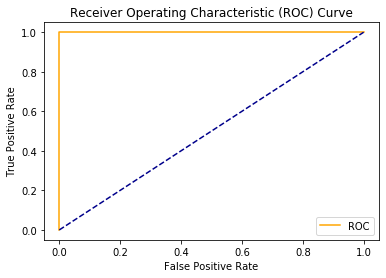

In [61]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
plot_roc_curve(fpr, tpr)

### Take Away Points :
* From this we can say all cases in X_test data are properly classified, having TPR = 1 and FPR = 0.
* This is due to row_sampling, column_smapling (i.e.,bootstrap sampling) and aggregation from random_forest.
* But perfect AUC=1 and perfect classification can be chance of overfit even in random forest, it gives wrong classification if differet test case comes in future to get classified.
* It always better train model on huge data as much as possible.